# BraTS 
In this Notebook we demonstrate how to utilize the BraTS package to use top performing algorithms from recent BraTS challenges.

---
## Getting Started

#### This tutorial requires:

   - Python 3.8+
   - Docker: Installation instructions on the official [website](https://docs.docker.com/get-docker/)


#### Optional but recommended:
   <!--CUDA 11.4+ (https://developer.nvidia.com/cuda-toolkit)-->
   - GPU with CUDA support (*otherwise CPU can be used for a some algorithms*) 
   - NVIDIA Container Toolkit: Refer to the [NVIDIA install guide](https://docs.nvidia.com/datacenter/cloud-native/container-toolkit/latest/install-guide.html) and the official [GitHub page](https://github.com/NVIDIA/nvidia-container-toolkit) 


In [1]:
# Installations
!pip install brats matplotlib ipywidgets > /dev/null

%load_ext autoreload
%autoreload 2

If you installed the packages and requirements on your own machine, you can skip this section and start from the import section.

### Setup Colab environment (optional) 
Otherwise you can follow and execute the tutorial on your browser.
In order to start working on the notebook, click on the following button, this will open this page in the Colab environment and you will be able to execute the code on your own (*Google account required*).

<a target="_blank" href="https://colab.research.google.com/github/BrainLesion/tutorials/blob/main/BraTS/tutorial.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

Now that you are visualizing the notebook in Colab, run the next cell to install the packages we will use. There are few things you should follow in order to properly set the notebook up:
1. Warning: This notebook was not authored by Google. Click on 'Run anyway'.
1. When the installation commands are done, there might be "Restart runtime" button at the end of the output. Please, click it.

If you run the next cell in a Google Colab environment, it will **clone the 'tutorials' repository** in your google drive. This will create a **new folder** called "tutorials" in **your Google Drive**.
All generated file will be created/uploaded to your Google Drive respectively.

After the first execution of the next cell, you might receive some warnings and notifications, please follow these instructions:
   - 'Permit this notebook to access your Google Drive files?' Click on 'Yes', and select your account.
   - Google Drive for desktop wants to access your Google Account. Click on 'Allow'.

Afterwards the "tutorials" folder has been created. You can navigate it through the lefthand panel in Colab. You might also have received an email that informs you about the access on your Google Drive.

In [2]:
import sys

# Check if we are in google colab currently
try:
    import google.colab

    colabFlag = True
except ImportError as r:
    colabFlag = False

# Execute certain steps only if we are in a colab environment
if colabFlag:
    # Create a folder in your Google Drive
    from google.colab import drive

    drive.mount("/content/drive")
    # clone repository and set path
    !git clone https://github.com/BrainLesion/tutorials.git /content/drive/MyDrive/tutorials
    BASE_PATH = "/content/drive/MyDrive/tutorials/BraTS/"
    sys.path.insert(0, BASE_PATH)

else:  # normal jupyter notebook environment
    BASE_PATH = "./"  # current working directory would be BraTs-Toolkit anyways if you are not in colab

## Imports

In [3]:
from pathlib import Path
from brats import AdultGliomaSegmenter
from brats.constants import AdultGliomaAlgorithms
import utils  # local file

---

## Data

AURORA expects *preprocessed* input data as NIfTI file or NumPy Array (*preprocessed* meaning the files should be co-registerend, skullstripped and in SRI-24 space).

In this example we provide sample data from the [ASNR-MICCAI BraTS Brain Metastasis Challenge](https://www.synapse.org/#!Synapse:syn51156910/wiki/622553), which is already preprocessed in the `AURORA/data` folder in the form of 4 modalities of the same brain (T1, T1C, T2, FLAIR). To get an intuition of the data, one example slice of the 3D scans is visualized below.

For your own data:
If the data is *not* preprocessed yet, consider using our [BrainLes preprocessing](https://github.com/BrainLesion/preprocessing) package (or its predecessor [BraTS-Toolkit](https://github.com/neuronflow/BraTS-Toolkit)).


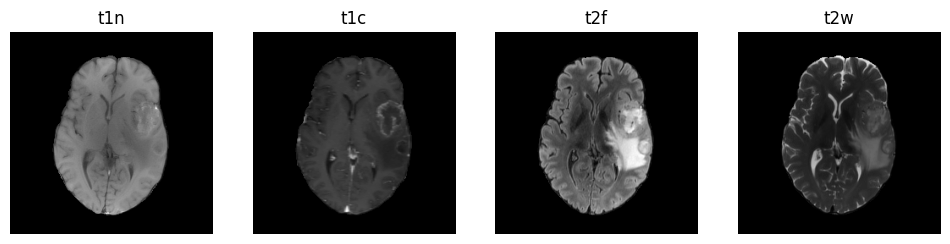

In [4]:
subject = "BraTS-GLI-00001-000"
data_path = Path(BASE_PATH) / "data"
subject_path = data_path / subject
utils.visualize_data(data_path, subject_id=subject)

## Using BraTS

### Minimal example using default settings

In [5]:
segmenter = AdultGliomaSegmenter(cuda_devices="1")
segmenter.infer_single(
    t1c=subject_path / f"{subject}-t1c.nii.gz",
    t1n=subject_path / f"{subject}-t1n.nii.gz",
    t2f=subject_path / f"{subject}-t2f.nii.gz",
    t2w=subject_path / f"{subject}-t2w.nii.gz",
    output_file="segmentation.nii.gz",
)

2024-07-23 17:31:59.144 | INFO     | brats.algorithms:__init__:47 - Instantiated AdultGliomaSegmenter with algorithm: BraTS23_1 by André Ferreira, et al.
2024-07-23 17:31:59.145 | INFO     | brats.algorithms:infer_single:90 - Performing single inference 
2024-07-23 17:31:59.158 | INFO     | brats.algorithms:_log_algorithm_info:53 - Running algorithm: BraTS23 Adult Glioma Segmentation (1st place)
2024-07-23 17:31:59.159 | INFO     | brats.algorithms:_log_algorithm_info:56 - (Docker image): brainles/brats23_faking_it:latest
2024-07-23 17:31:59.160 | INFO     | brats.algorithms:_log_algorithm_info:59 - (Paper) Consider citing the corresponding paper: https://arxiv.org/abs/2402.17317v1 by André Ferreira, et al.
2024-07-23 17:31:59.301 | INFO     | brats.docker:run_docker:243 - Starting inference
2024-07-23 17:35:29.255 | INFO     | brats.docker:run_docker:268 - Finished inference
2024-07-23 17:35:29.257 | INFO     | brats.algorithms:infer_single:119 - Saved segmentation to: /home/ivan_marc

### Visualize results

The segementation comprise of the
TODO


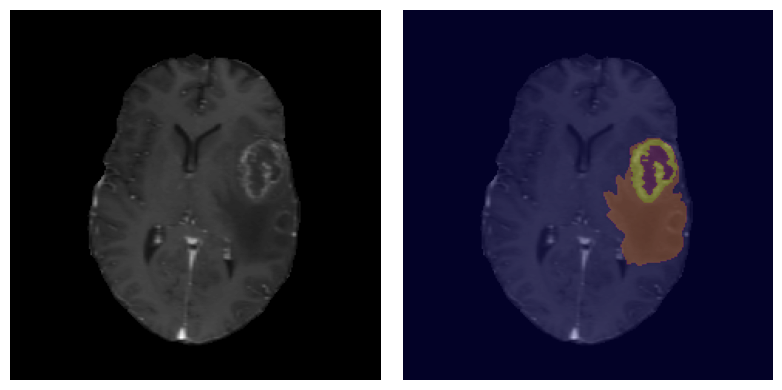

In [5]:
utils.visualize_segmentation(
    modality_file=subject_path / f"{subject}-t1c.nii.gz",
    segmentation_file="segmentation.nii.gz",
)

## Batch processing

BraTS allows to run an algorithm for a single set of input images (t1n, t1c, t2f, t2w of the same patient) or for multiple subjects.
Each of the available classes provides methods for both: 
- `.infer_single(...)` that takes in the paths to the required input modalities and a path to store the result
- `.infer_batch(...)` that takes in a path to a data folder containing multiple sets of subjects and a path to an output folder to store the results

The sets of subject inputs need to be stored in a specific structure to be recognized by the package:
```
data_folder
┣ A
┃ ┣ A-t1c.nii.gz
┃ ┣ A-t1n.nii.gz
┃ ┣ A-t2f.nii.gz
┃ ┗ A-t2w.nii.gz
┣ B
┃ ┣ B-t1c.nii.gz
┃ ┣ ...
```

In [5]:
output_path = Path("batch_out")

segmenter = AdultGliomaSegmenter(cuda_devices="1")
segmenter.infer_batch(
    data_folder=data_path,
    output_folder=output_path,
)

print([path.name for path in output_path.iterdir()])

2024-07-23 19:59:18.168 | INFO     | brats.algorithms:__init__:47 - Instantiated AdultGliomaSegmenter with algorithm: BraTS23_1 by André Ferreira, et al.
2024-07-23 19:59:18.171 | INFO     | brats.algorithms:_log_algorithm_info:53 - Running algorithm: BraTS23 Adult Glioma Segmentation (1st place)
2024-07-23 19:59:18.172 | INFO     | brats.algorithms:_log_algorithm_info:56 - (Docker image): brainles/brats23_faking_it:latest
2024-07-23 19:59:18.173 | INFO     | brats.algorithms:_log_algorithm_info:59 - (Paper) Consider citing the corresponding paper: https://arxiv.org/abs/2402.17317v1 by André Ferreira, et al.
2024-07-23 19:59:18.175 | INFO     | brats.algorithms:infer_batch:165 - Found 2 subjects: BraTS-GLI-00001-001, BraTS-GLI-00001-000 
2024-07-23 19:59:18.208 | INFO     | brats.algorithms:infer_batch:174 - Standardized input names to match algorithm requirements.


2024-07-23 19:59:18.385 | INFO     | brats.docker:run_docker:243 - Starting inference
2024-07-23 20:03:42.416 | INFO     | brats.docker:run_docker:268 - Finished inference
2024-07-23 20:03:42.418 | INFO     | brats.algorithms:infer_batch:191 - Saved results to: /home/ivan_marcel/tutorials/BraTS/batch_out


['BraTS-GLI-00001-000.nii.gz', 'BraTS-GLI-00001-001.nii.gz']


## Advanced Usage

By default the algorithm that won the most recent challenge will be run on the first available GPU. This behavior and other options can be adapted, e.g.:
- Select a different algorithm from the available constants (Enum classes for each challenge) with the `algorithm` parameter
- Select a specific GPU if multiple are available with the `cuda_decives` parameter
- Force CPU execution with the `force_cpu`flag (will cause an exception for many algorithms since many do not support CPU execution)
- Save the generated logs in a log file with the `log_file` parameter

In [6]:
segmenter = AdultGliomaSegmenter(
    algorithm=AdultGliomaAlgorithms.BraTS23_3,  # Use the 3rd placed algorithm of the Adult Glioma BraTS 2023 challenge
    cuda_devices="4",  # Select GPU device with ID 4
    force_cpu=False,  # default, could be set to True to force CPU
)

segmenter.infer_single(
    t1c=subject_path / f"{subject}-t1c.nii.gz",
    t1n=subject_path / f"{subject}-t1n.nii.gz",
    t2f=subject_path / f"{subject}-t2f.nii.gz",
    t2w=subject_path / f"{subject}-t2w.nii.gz",
    output_file="segmentation.nii.gz",
    log_file="segmentation.log",  # Save the logs in a new filed called `segmentation.log`
)

2024-07-23 20:15:40.003 | INFO     | brats.algorithms:__init__:47 - Instantiated AdultGliomaSegmenter with algorithm: BraTS23_3 by Fadillah Adamsyah Maani, et al.
2024-07-23 20:15:40.007 | INFO     | brats.algorithms:infer_single:87 - Logging to: /home/ivan_marcel/tutorials/BraTS/segmentation.log
2024-07-23 20:15:40.008 | INFO     | brats.algorithms:infer_single:90 - Performing single inference 
2024-07-23 20:15:40.017 | INFO     | brats.algorithms:_log_algorithm_info:53 - Running algorithm: BraTS23 Adult Glioma Segmentation (3rd place)
2024-07-23 20:15:40.018 | INFO     | brats.algorithms:_log_algorithm_info:56 - (Docker image): brainles/brats23_biomedmbz:latest
2024-07-23 20:15:40.018 | INFO     | brats.algorithms:_log_algorithm_info:59 - (Paper) Consider citing the corresponding paper: N/A by Fadillah Adamsyah Maani, et al.
2024-07-23 20:15:40.600 | INFO     | brats.weights:check_model_weights:54 - Found downloaded local weights: 11573315_v1.0.1
2024-07-23 20:15:40.601 | INFO     | 

## Algorithms from other Challenges

BraTS provides the algorithms from all available recent BraTS Challenges, i.e.:
- Adult Glioma Segmentation
- BraTS-Africa Segmentation
- Meningioma Segmentation
- Brain Metastases Segmentation
- Pediatric Tumors Segmentation
- Inpainting

The package provides a separate class and algorithm constants for each of the challenges.<br>
The examples above were demonstrated using the class and constants of the Adult Glioma Segmentation challenge.

In an identical way you can use:
- `MeningiomaSegmenter` class with `MeningiomaAlgorithms`
- `PediatricSegmenter` class with `PediatricAlgorithms`
- etc.

In [6]:
# e.g. for the Meningioma Algorithms
from brats import MeningiomaSegmenter
from brats.constants import MeningiomaAlgorithms

segmenter = MeningiomaSegmenter(
    algorithm=MeningiomaAlgorithms.BraTS23_2, cuda_devices="1"
)
segmenter.infer_batch(
    data_folder=data_path, output_folder="men_output", log_file="test.log"
)

2024-07-23 20:55:41.467 | INFO     | brats.algorithms:__init__:47 - Instantiated MeningiomaSegmenter with algorithm: BraTS23_2 by Ziyan Huang
2024-07-23 20:55:41.471 | INFO     | brats.algorithms:infer_batch:160 - Logging to: /home/ivan_marcel/tutorials/BraTS/test.log
2024-07-23 20:55:41.472 | INFO     | brats.algorithms:_log_algorithm_info:53 - Running algorithm: BraTS23 Meningioma Segmentation (2nd place)
2024-07-23 20:55:41.473 | INFO     | brats.algorithms:_log_algorithm_info:56 - (Docker image): brainles/brats23_meningioma_blackbean:latest
2024-07-23 20:55:41.474 | INFO     | brats.algorithms:_log_algorithm_info:59 - (Paper) Consider citing the corresponding paper: N/A by Ziyan Huang
2024-07-23 20:55:41.475 | INFO     | brats.algorithms:infer_batch:165 - Found 2 subjects: BraTS-GLI-00001-001, BraTS-GLI-00001-000 
2024-07-23 20:55:41.506 | INFO     | brats.algorithms:infer_batch:174 - Standardized input names to match algorithm requirements.
2024-07-23 20:55:41.641 | INFO     | bra